In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('/kaggle/input/car-hacking-dataset/DoS_dataset.csv')
df.columns = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
df.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478198e+09,018f,8,fe,5b,00,00,00,3c,00,00,R
1,1.478198e+09,0260,8,19,21,22,30,08,8e,6d,3a,R
2,1.478198e+09,02a0,8,64,00,9a,1d,97,02,bd,00,R
3,1.478198e+09,0329,8,40,bb,7f,14,11,20,00,14,R
4,1.478198e+09,0545,8,d8,00,00,8a,00,00,00,00,R


In [4]:
df.describe()

,Timestamp,DLC
count,3.665770e+06,3.665770e+06
mean,1.478200e+09,7.948953e+00
std,8.471848e+02,5.510704e-01
min,1.478198e+09,2.000000e+00
25%,1.478199e+09,8.000000e+00
50%,1.478200e+09,8.000000e+00
75%,1.478201e+09,8.000000e+00
max,1.478201e+09,8.000000e+00


In [5]:
df_2 = df.copy()
# Convert 'Timestamp' to datetime
df_2['Timestamp'] = pd.to_datetime(df_2['Timestamp'], unit='ms')

# Set Timestamp as the index
df_2 = df_2.set_index('Timestamp')

# Calculate time intervals between messages
df_2['Time_delta'] = df_2.index.to_series().diff()

# Count occurrences of '0000' CAN IDs in a 300ms rolling window
df_2['0000_Count'] = (df_2['CAN ID'] == '0000').astype(int).rolling('300ms').sum()

df_2.head()


,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag,Time_delta,0000_Count
Timestamp,,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,8,fe,5b,00,00,00,3c,00,00,R,NaT,0.0
1970-01-18 02:36:38.376389864,0260,8,19,21,22,30,08,8e,6d,3a,R,0 days 00:00:00.000000228,0.0
1970-01-18 02:36:38.376390096,02a0,8,64,00,9a,1d,97,02,bd,00,R,0 days 00:00:00.000000232,0.0
1970-01-18 02:36:38.376390333,0329,8,40,bb,7f,14,11,20,00,14,R,0 days 00:00:00.000000237,0.0
1970-01-18 02:36:38.376390574,0545,8,d8,00,00,8a,00,00,00,00,R,0 days 00:00:00.000000241,0.0


In [6]:
df_2['Time_delta'] = df_2['Time_delta'].fillna(pd.Timedelta(seconds=0))  # Replace NaT with 0 seconds
df_2.head()

,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag,Time_delta,0000_Count
Timestamp,,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,8,fe,5b,00,00,00,3c,00,00,R,0 days 00:00:00,0.0
1970-01-18 02:36:38.376389864,0260,8,19,21,22,30,08,8e,6d,3a,R,0 days 00:00:00.000000228,0.0
1970-01-18 02:36:38.376390096,02a0,8,64,00,9a,1d,97,02,bd,00,R,0 days 00:00:00.000000232,0.0
1970-01-18 02:36:38.376390333,0329,8,40,bb,7f,14,11,20,00,14,R,0 days 00:00:00.000000237,0.0
1970-01-18 02:36:38.376390574,0545,8,d8,00,00,8a,00,00,00,00,R,0 days 00:00:00.000000241,0.0


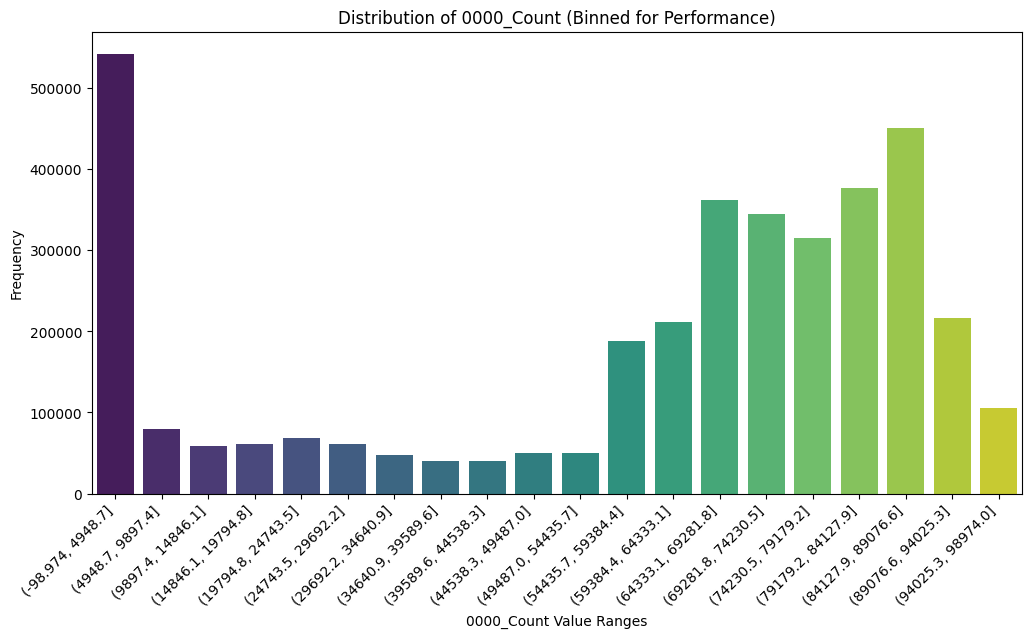

In [7]:


# Filter out 0 values and make a copy to avoid SettingWithCopyWarning
df_count = df_2.copy()

# Use bins for better performance
num_bins = 20  # Adjust based on data size
df_count["0000_Count_Binned"] = pd.cut(df_count["0000_Count"], bins=num_bins)

# Count occurrences of each bin
binned_counts = df_count["0000_Count_Binned"].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=binned_counts.index.astype(str), y=binned_counts.values, palette="viridis")

# Labels and formatting
plt.xlabel("0000_Count Value Ranges")
plt.ylabel("Frequency")
plt.title("Distribution of 0000_Count (Binned for Performance)")
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()




In [8]:
# Drop unnecessary columns
df_3 = df_2.drop(["DLC"], axis=1).copy()
df_3.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag,Time_delta,0000_Count
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,fe,5b,00,00,00,3c,00,00,R,0 days 00:00:00,0.0
1970-01-18 02:36:38.376389864,0260,19,21,22,30,08,8e,6d,3a,R,0 days 00:00:00.000000228,0.0
1970-01-18 02:36:38.376390096,02a0,64,00,9a,1d,97,02,bd,00,R,0 days 00:00:00.000000232,0.0
1970-01-18 02:36:38.376390333,0329,40,bb,7f,14,11,20,00,14,R,0 days 00:00:00.000000237,0.0
1970-01-18 02:36:38.376390574,0545,d8,00,00,8a,00,00,00,00,R,0 days 00:00:00.000000241,0.0


In [9]:
df_3.dtypes, df_3.shape

(CAN ID                 object
 DATA0                  object
 DATA1                  object
 DATA2                  object
 DATA3                  object
 DATA4                  object
 DATA5                  object
 DATA6                  object
 DATA7                  object
 Flag                   object
 Time_delta    timedelta64[ns]
 0000_Count            float64
 dtype: object,
 (3665770, 12))

In [10]:
df_2 = df.copy()

In [11]:
df_3.describe()

,Time_delta,0000_Count
count,3665770,3.665770e+06
mean,0 days 00:00:00.000000772,5.779000e+04
std,0 days 00:00:00.000011766,3.145933e+04
min,0 days 00:00:00,0.000000e+00
25%,0 days 00:00:00.000000238,3.442500e+04
50%,0 days 00:00:00.000000245,6.900100e+04
75%,0 days 00:00:00.000000300,8.192100e+04
max,0 days 00:00:00.022358267,9.897400e+04


In [12]:
# Move 'Flag' column to the end
df_3 = df_3[[
    col for col in df_3.columns if col != 'Flag'
] + ['Flag']]
df_3.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,fe,5b,00,00,00,3c,00,00,0 days 00:00:00,0.0,R
1970-01-18 02:36:38.376389864,0260,19,21,22,30,08,8e,6d,3a,0 days 00:00:00.000000228,0.0,R
1970-01-18 02:36:38.376390096,02a0,64,00,9a,1d,97,02,bd,00,0 days 00:00:00.000000232,0.0,R
1970-01-18 02:36:38.376390333,0329,40,bb,7f,14,11,20,00,14,0 days 00:00:00.000000237,0.0,R
1970-01-18 02:36:38.376390574,0545,d8,00,00,8a,00,00,00,00,0 days 00:00:00.000000241,0.0,R


In [13]:
df_4 = df_3.copy()
# Function to convert hex to decimal
def hex_to_int(hex_str: str) -> int:
    try:
        return int(str(hex_str).strip(), 16)  # Convert hex to int
    except ValueError:
        return np.nan 

# Convert all DATA columns
for col in df_4.columns[1:-3]:  # Exclude 'Flag' column
    df_4[col] = df_4[col].apply(hex_to_int)

In [14]:
df_4.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0.0,0.0,0.0,60.0,0.0,0.0,0 days 00:00:00,0.0,R
1970-01-18 02:36:38.376389864,0260,25,33,34.0,48.0,8.0,142.0,109.0,58.0,0 days 00:00:00.000000228,0.0,R
1970-01-18 02:36:38.376390096,02a0,100,0,154.0,29.0,151.0,2.0,189.0,0.0,0 days 00:00:00.000000232,0.0,R
1970-01-18 02:36:38.376390333,0329,64,187,127.0,20.0,17.0,32.0,0.0,20.0,0 days 00:00:00.000000237,0.0,R
1970-01-18 02:36:38.376390574,0545,216,0,0.0,138.0,0.0,0.0,0.0,0.0,0 days 00:00:00.000000241,0.0,R


In [15]:
df_5 = df_4.copy()
df_5.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0.0,0.0,0.0,60.0,0.0,0.0,0 days 00:00:00,0.0,R
1970-01-18 02:36:38.376389864,0260,25,33,34.0,48.0,8.0,142.0,109.0,58.0,0 days 00:00:00.000000228,0.0,R
1970-01-18 02:36:38.376390096,02a0,100,0,154.0,29.0,151.0,2.0,189.0,0.0,0 days 00:00:00.000000232,0.0,R
1970-01-18 02:36:38.376390333,0329,64,187,127.0,20.0,17.0,32.0,0.0,20.0,0 days 00:00:00.000000237,0.0,R
1970-01-18 02:36:38.376390574,0545,216,0,0.0,138.0,0.0,0.0,0.0,0.0,0 days 00:00:00.000000241,0.0,R


In [16]:
df_5["Flag"] = df_4["Flag"].map({"R": 0, "T": 1})
df_5.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0.0,0.0,0.0,60.0,0.0,0.0,0 days 00:00:00,0.0,0.0
1970-01-18 02:36:38.376389864,0260,25,33,34.0,48.0,8.0,142.0,109.0,58.0,0 days 00:00:00.000000228,0.0,0.0
1970-01-18 02:36:38.376390096,02a0,100,0,154.0,29.0,151.0,2.0,189.0,0.0,0 days 00:00:00.000000232,0.0,0.0
1970-01-18 02:36:38.376390333,0329,64,187,127.0,20.0,17.0,32.0,0.0,20.0,0 days 00:00:00.000000237,0.0,0.0
1970-01-18 02:36:38.376390574,0545,216,0,0.0,138.0,0.0,0.0,0.0,0.0,0 days 00:00:00.000000241,0.0,0.0


In [17]:
print(df_4["Flag"].unique())

['R' nan 'T']


In [18]:
filtered_df2 = df_5[df_5["CAN ID"] == "0000"]
filtered_df2.head(), filtered_df2.shape

(                              CAN ID  DATA0  DATA1  DATA2  DATA3  DATA4  \
 Timestamp                                                                 
 1970-01-18 02:36:38.377185137   0000      0      0    0.0    0.0    0.0   
 1970-01-18 02:36:38.377185629   0000      0      0    0.0    0.0    0.0   
 1970-01-18 02:36:38.377186119   0000      0      0    0.0    0.0    0.0   
 1970-01-18 02:36:38.377186612   0000      0      0    0.0    0.0    0.0   
 1970-01-18 02:36:38.377187116   0000      0      0    0.0    0.0    0.0   
 
                                DATA5  DATA6  DATA7                Time_delta  \
 Timestamp                                                                      
 1970-01-18 02:36:38.377185137    0.0    0.0    0.0 0 days 00:00:00.000000238   
 1970-01-18 02:36:38.377185629    0.0    0.0    0.0 0 days 00:00:00.000000244   
 1970-01-18 02:36:38.377186119    0.0    0.0    0.0 0 days 00:00:00.000000239   
 1970-01-18 02:36:38.377186612    0.0    0.0    0.0 0 days 00

In [19]:
df_5.shape,df_5.dtypes

((3665770, 12),
 CAN ID                 object
 DATA0                   int64
 DATA1                   int64
 DATA2                 float64
 DATA3                 float64
 DATA4                 float64
 DATA5                 float64
 DATA6                 float64
 DATA7                 float64
 Time_delta    timedelta64[ns]
 0000_Count            float64
 Flag                  float64
 dtype: object)

In [20]:
df_5.isnull().sum()

CAN ID            0
DATA0             0
DATA1             0
DATA2         31188
DATA3         31188
DATA4         31188
DATA5         31188
DATA6         31188
DATA7         31188
Time_delta        0
0000_Count        0
Flag          31188
dtype: int64

In [21]:
df_6 = df_5.dropna().copy()
df_6.shape

(3634582, 12)

In [22]:
print(df_6["Flag"].unique())

[0. 1.]


In [23]:
df_6.isnull().sum(), df_6.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3634582 entries, 1970-01-18 02:36:38.376389636 to 1970-01-18 02:36:41.209058944
Data columns (total 12 columns):
 #   Column      Dtype          
---  ------      -----          
 0   CAN ID      object         
 1   DATA0       int64          
 2   DATA1       int64          
 3   DATA2       float64        
 4   DATA3       float64        
 5   DATA4       float64        
 6   DATA5       float64        
 7   DATA6       float64        
 8   DATA7       float64        
 9   Time_delta  timedelta64[ns]
 10  0000_Count  float64        
 11  Flag        float64        
dtypes: float64(8), int64(2), object(1), timedelta64[ns](1)
memory usage: 360.5+ MB


(CAN ID        0
 DATA0         0
 DATA1         0
 DATA2         0
 DATA3         0
 DATA4         0
 DATA5         0
 DATA6         0
 DATA7         0
 Time_delta    0
 0000_Count    0
 Flag          0
 dtype: int64,
 None)

In [24]:
# Convert columns to int64 including timestamp mcolumn
df_6 = df_6.astype({"DATA0": "int64", "DATA1": "int64",
                    "DATA2": "int64", "DATA3": "int64", "DATA4": "int64",
                    "DATA5": "int64", "DATA6": "int64", "DATA7": "int64",
                    "Time_delta": "int64", "0000_Count": "int64", "Flag": "int64"})

In [25]:
df_6.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0,0,0,60,0,0,0,0,0
1970-01-18 02:36:38.376389864,0260,25,33,34,48,8,142,109,58,228,0,0
1970-01-18 02:36:38.376390096,02a0,100,0,154,29,151,2,189,0,232,0,0
1970-01-18 02:36:38.376390333,0329,64,187,127,20,17,32,0,20,237,0,0
1970-01-18 02:36:38.376390574,0545,216,0,0,138,0,0,0,0,241,0,0


In [26]:
df_6.dtypes

CAN ID        object
DATA0          int64
DATA1          int64
DATA2          int64
DATA3          int64
DATA4          int64
DATA5          int64
DATA6          int64
DATA7          int64
Time_delta     int64
0000_Count     int64
Flag           int64
dtype: object

In [27]:
df_6.describe()

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
count,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06,3.634582e+06
mean,5.095562e+01,3.774545e+01,3.063615e+01,5.449552e+01,3.922035e+01,5.668486e+01,2.197127e+01,4.089031e+01,7.720875e+02,5.782381e+04,1.616475e-01
std,8.836175e+01,5.223686e+01,5.322283e+01,8.867384e+01,6.830257e+01,7.719327e+01,5.266569e+01,6.758418e+01,1.181627e+04,3.144320e+04,3.681272e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.390000e+02,3.479100e+04,0.000000e+00
50%,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,2.450000e+02,6.901500e+04,0.000000e+00
75%,3.600000e+01,3.900000e+01,3.500000e+01,1.040000e+02,3.500000e+01,1.270000e+02,9.000000e+00,5.900000e+01,2.890000e+02,8.194200e+04,0.000000e+00
max,2.550000e+02,1.920000e+02,2.520000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.090000e+02,2.550000e+02,2.235827e+07,9.897400e+04,1.000000e+00


In [28]:
df_7 = df_6.copy()
df_7.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,018f,254,91,0,0,0,60,0,0,0,0,0
1970-01-18 02:36:38.376389864,0260,25,33,34,48,8,142,109,58,228,0,0
1970-01-18 02:36:38.376390096,02a0,100,0,154,29,151,2,189,0,232,0,0
1970-01-18 02:36:38.376390333,0329,64,187,127,20,17,32,0,20,237,0,0
1970-01-18 02:36:38.376390574,0545,216,0,0,138,0,0,0,0,241,0,0


In [29]:
filtered_df3 = df_7[(df_7["CAN ID"] == "0000")]
filtered_df3.shape

(587521, 12)

In [30]:
# Exclude the 'Flag' column before calculating correlation
correlation_matrix = df_7.drop(columns=['CAN ID','Flag', 'Time_delta', '0000_Count']).corr()
correlation_matrix

,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7
DATA0,1.000000,0.262622,-0.087865,-0.121826,0.301022,0.159252,-0.086027,-0.161409
DATA1,0.262622,1.000000,0.245918,0.246772,-0.002113,0.272086,-0.198364,0.192120
DATA2,-0.087865,0.245918,1.000000,0.146732,0.365238,-0.042852,0.307529,0.131026
DATA3,-0.121826,0.246772,0.146732,1.000000,0.141884,0.613955,0.017878,0.035810
DATA4,0.301022,-0.002113,0.365238,0.141884,1.000000,0.349199,0.191276,0.016340
DATA5,0.159252,0.272086,-0.042852,0.613955,0.349199,1.000000,0.064044,-0.036581
DATA6,-0.086027,-0.198364,0.307529,0.017878,0.191276,0.064044,1.000000,-0.081293
DATA7,-0.161409,0.192120,0.131026,0.035810,0.016340,-0.036581,-0.081293,1.000000


<Axes: >

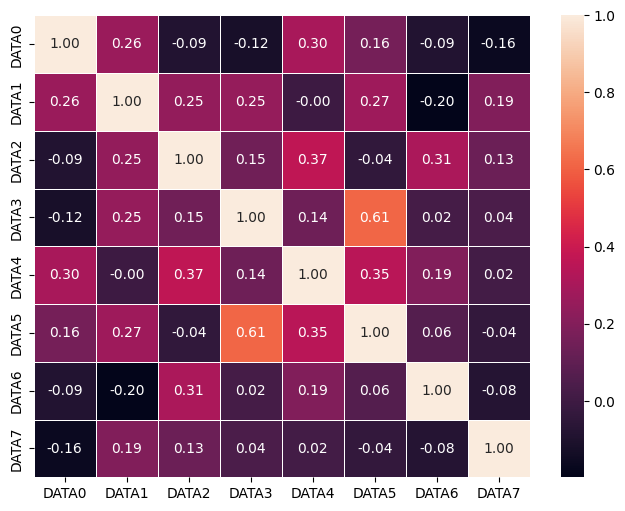

In [31]:
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5)

In [32]:
filtered_df4 = df_7[(df_7["Flag"] == 1) & (df_7["CAN ID"] == "0000")]
filtered_df4.shape

(587521, 12)

In [33]:
df_8 = df_7.copy()
# Load the dataset (assuming df_7 is already a DataFrame)
df_8['CAN ID'] = df_8['CAN ID'].apply(lambda x: int(x, 16))  # Convert hex to integer
df_8['CAN ID'] = df_8['CAN ID'].astype(int)
df_8.head()

,CAN ID,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Time_delta,0000_Count,Flag
Timestamp,,,,,,,,,,,,
1970-01-18 02:36:38.376389636,399,254,91,0,0,0,60,0,0,0,0,0
1970-01-18 02:36:38.376389864,608,25,33,34,48,8,142,109,58,228,0,0
1970-01-18 02:36:38.376390096,672,100,0,154,29,151,2,189,0,232,0,0
1970-01-18 02:36:38.376390333,809,64,187,127,20,17,32,0,20,237,0,0
1970-01-18 02:36:38.376390574,1349,216,0,0,138,0,0,0,0,241,0,0


In [34]:
df_9 = df_8.drop(columns=['Time_delta', '0000_Count'], axis=1)
df_9 = df_9.reset_index(drop=True)
df_9.head(), df_9['Flag'].value_counts()

(   CAN ID  DATA0  DATA1  DATA2  DATA3  DATA4  DATA5  DATA6  DATA7  Flag
 0     399    254     91      0      0      0     60      0      0     0
 1     608     25     33     34     48      8    142    109     58     0
 2     672    100      0    154     29    151      2    189      0     0
 3     809     64    187    127     20     17     32      0     20     0
 4    1349    216      0      0    138      0      0      0      0     0,
 Flag
 0    3047061
 1     587521
 Name: count, dtype: int64)

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

# ✅ Detect GPU availability
GPU_AVAILABLE = os.path.exists('/dev/nvidia0')

try:
    if GPU_AVAILABLE:
        import cudf  # GPU DataFrame
        import cupy as cp  # GPU NumPy
        from cuml.ensemble import RandomForestClassifier as cuRF  # GPU RF
        print("🚀 RAPIDS cuML available! Running on GPU")
    else:
        raise ImportError
except ImportError:
    GPU_AVAILABLE = False
    print("⚡ RAPIDS not available. Running on CPU.")

# 📌 Load dataset (Ensure df_9 is preloaded)
df_10 = df_9.copy()

# Define features and target
X = df_10.drop(columns=['Flag'])
y = df_10['Flag']

# ✅ Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# ✅ Convert to GPU DataFrame if available
if GPU_AVAILABLE:
    X_resampled = cudf.DataFrame(X_resampled)
    y_resampled = cudf.Series(y_resampled)

# ✅ Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# ✅ Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ✅ Choose the model (GPU vs CPU)
if GPU_AVAILABLE:
    print("🚀 Using GPU-Accelerated Random Forest (cuML)")
    model = cuRF(n_estimators=100, random_state=42)
else:
    print("⚡ Using CPU-based Random Forest")
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1)

# ✅ Train the model
model.fit(X_train_scaled, y_train)

# ✅ Predictions
y_pred = model.predict(X_test_scaled)

# ✅ Convert predictions to NumPy if using GPU
if GPU_AVAILABLE:
    y_pred = y_pred.get()

# ✅ Evaluate the model
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


⚡ RAPIDS not available. Running on CPU.


In [ ]:
# import os
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report
# from imblearn.over_sampling import SMOTE

# # 📌 Load dataset (Ensure df_9 is preloaded)
# df_10 = df_9.copy()

# # Define features and target
# X = df_10.drop(columns=['Flag'])
# y = df_10['Flag']

# # ✅ Handle class imbalance using SMOTE
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # ✅ Split into train/test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
# )

# # ✅ Standardize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # ✅ Use CPU-Optimized RandomForest
# print("⚡ Running on CPU (Kaggle GPU is incompatible with RAPIDS)")
# model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1)

# # ✅ Train the model
# model.fit(X_train_scaled, y_train)

# # ✅ Predictions
# y_pred = model.predict(X_test_scaled)

# # ✅ Evaluate the model
# print("✅ Accuracy:", accuracy_score(y_test, y_pred))
# print(classification_report(y_test, y_pred))
